# Swift UVOT Events

## Reading in Data

In [98]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import Angle, SkyCoord
from regions import CircleSkyRegion
from scipy.optimize import curve_fit
from photutils.detection import DAOStarFinder
from astropy.stats import sigma_clipped_stats

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [4]:
eventFile = fits.open('/home/saphio/sw00094137009um2w1po_uf.evt.gz')
imgFile = fits.open('/home/saphio/sw00094137009u_sk.img.gz')

primaryHdu = imgFile[0]
imgHdu = imgFile[1]

wcs = WCS(imgHdu.header)

events = eventFile[1].data

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 59236.264051 from DATE-OBS.
Set MJD-END to 59236.548553 from DATE-END'. [astropy.wcs.wcs]


In [6]:
events

FITS_rec([(6.32983520e+08,   1867,   1370, 1916, 1439, 2238, 1547, 1,   0),
          (6.32983520e+08,   1534,   1402, 1593, 1476, 2137, 1857, 1,   0),
          (6.32983520e+08,   2039,   1420, 2079, 1486, 2348, 1419, 1,   0),
          ...,
          (6.33013801e+08,   1164,   1636, 1229, 1718, 2616, 2093, 6, 256),
          (6.33013801e+08,    347,   1727,  432, 1810, 2294, 2827, 6, 256),
          (6.33013801e+08,   1453,   1997, 1503, 2069, 3058, 2034, 6, 256)],
         dtype=(numpy.record, [('TIME', '>f8'), ('RAWX', '>i2'), ('RAWY', '>i2'), ('DETX', '>i2'), ('DETY', '>i2'), ('X', '>i2'), ('Y', '>i2'), ('EXPREF', '>i2'), ('QUALITY', '>i2')]))

In [7]:
wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 116.110733 3.551811 
CRPIX : 1604.5 1583.5 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.000139444442 0.000139444442 
NAXIS : 3208  3166

## Cleaning Event Data

In [8]:
events_clean = events[np.where((events.QUALITY == 0))]
## quality flag of 0 = good
print(f'removed {len(events) - len(events_clean)} events')

removed 1952995 events


## Displaying Event Data

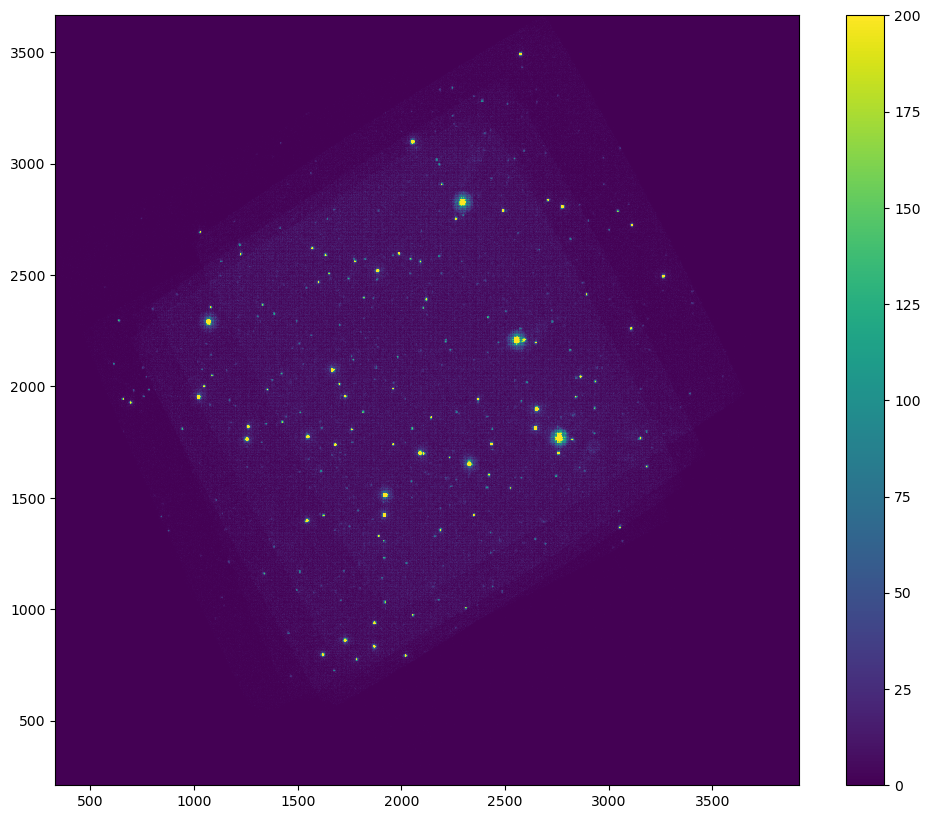

In [75]:
plt.figure(figsize=(12, 10))

histdata, x, y, img = plt.hist2d(events_clean.X, events_clean.Y, bins=1000, vmin=0, vmax=200)
plt.colorbar()

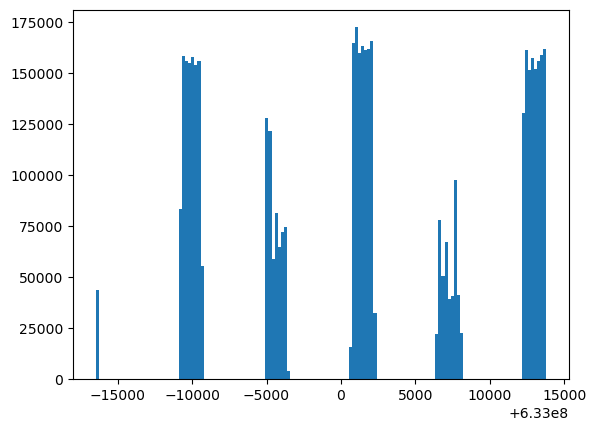

In [25]:
times = plt.hist(events_clean['TIME'], bins='auto')

In [28]:
## selecting a time period with continuous data

def evtInterval(tStart, tStop, evtList):
    interval = evtList [np.where((evtList.TIME > tStart) &
                                 (evtList.TIME < tStop))]
    
    return interval

## Practicing Making Images of Intervals

In [37]:
interval0 = evtInterval(632980000, 632985000, events_clean)
interval1 = evtInterval(632985000, 632992500, events_clean)
interval2 = evtInterval(632992500, 633000000, events_clean)
interval3 = evtInterval(633000000, 633003000, events_clean)
interval4 = evtInterval(633005000, 633010000, events_clean)
interval5 = evtInterval(633010000, 633015000, events_clean)

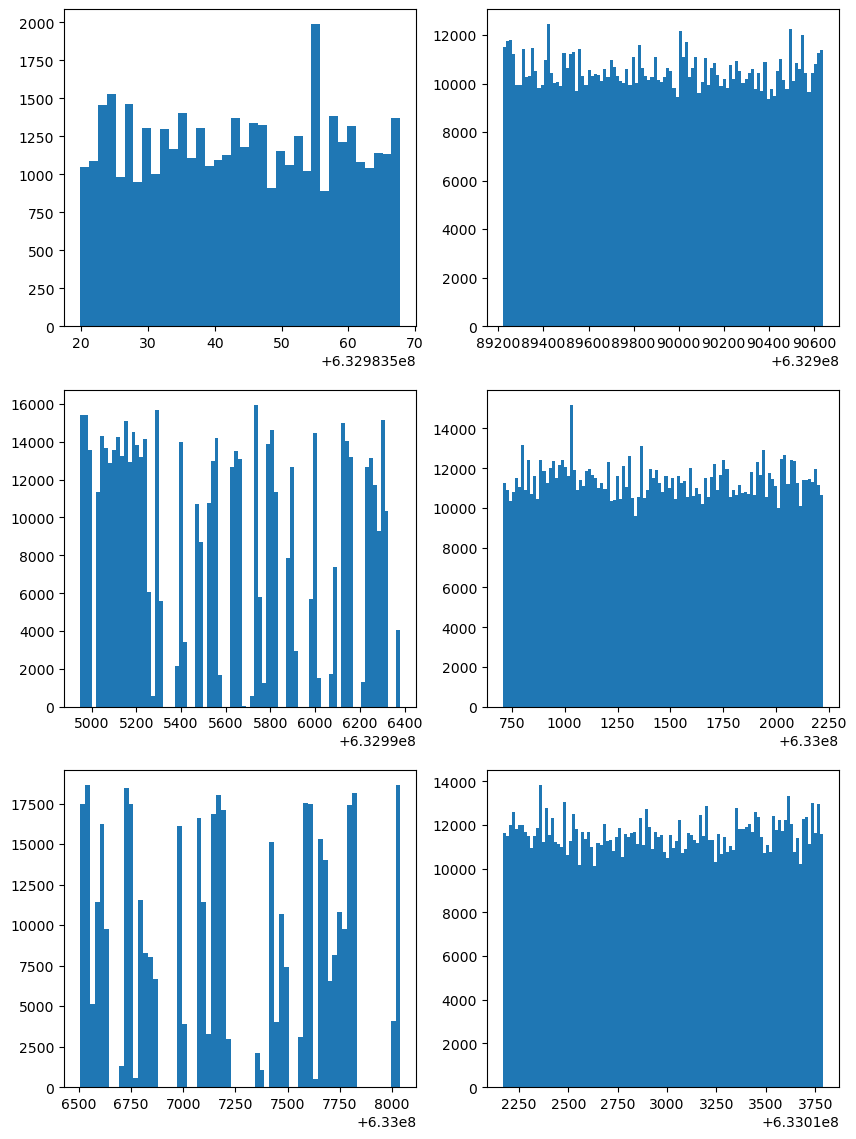

In [38]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 14))
_ = axes[0][0].hist(interval0['TIME'], bins='auto')
_ = axes[0][1].hist(interval1['TIME'], bins='auto')
_ = axes[1][0].hist(interval2['TIME'], bins='auto')
_ = axes[1][1].hist(interval3['TIME'], bins='auto')
_ = axes[2][0].hist(interval4['TIME'], bins='auto')
_ = axes[2][1].hist(interval5['TIME'], bins='auto')

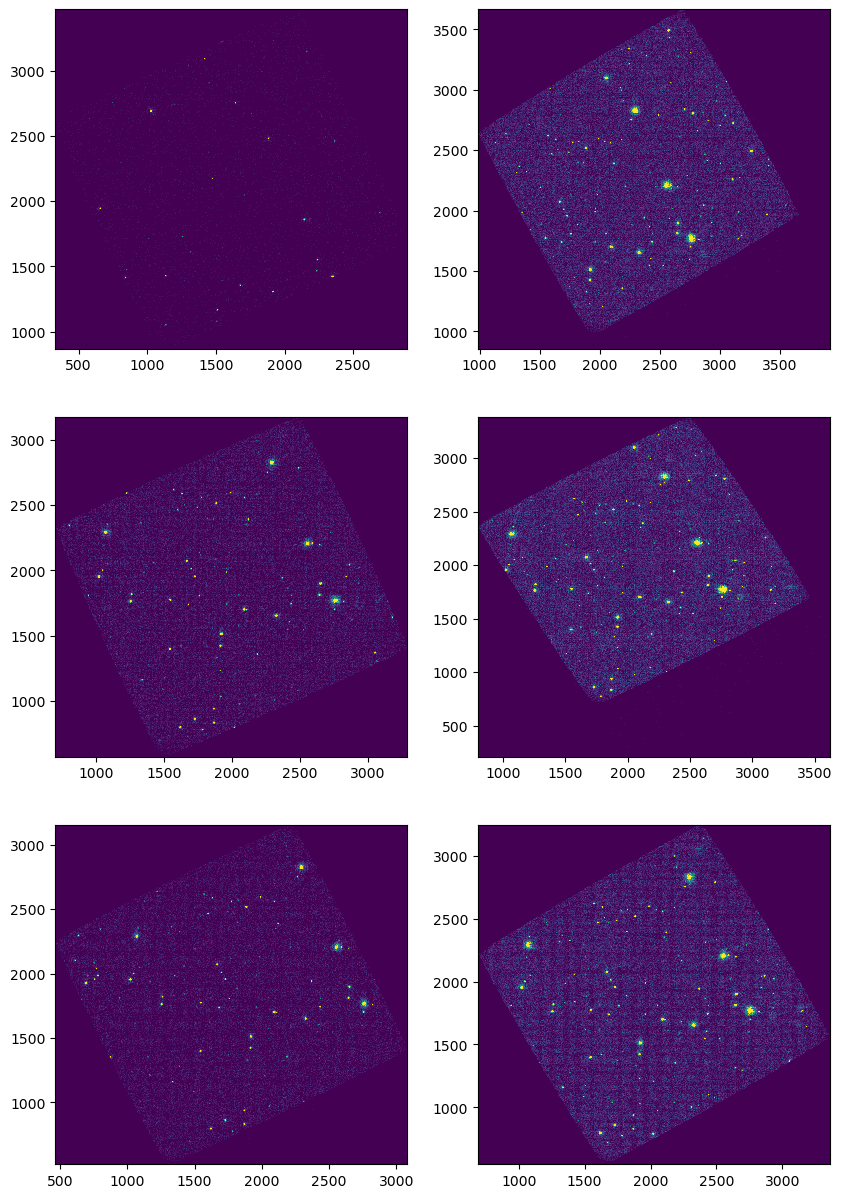

In [43]:
## visualization

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 15))

histdata, x, y, img = axes[0][0].hist2d(interval0.X, interval0.Y, bins=1000, vmin=0, vmax = 20)
histdata, x, y, img = axes[0][1].hist2d(interval1.X, interval1.Y, bins=1000, vmin=0, vmax = 20)
histdata, x, y, img = axes[1][0].hist2d(interval2.X, interval2.Y, bins=1000, vmin=0, vmax = 20)
histdata, x, y, img = axes[1][1].hist2d(interval3.X, interval3.Y, bins=1000, vmin=0, vmax = 20)
histdata, x, y, img = axes[2][0].hist2d(interval4.X, interval4.Y, bins=1000, vmin=0, vmax = 20)
histdata, x, y, img = axes[2][1].hist2d(interval5.X, interval5.Y, bins=1000, vmin=0, vmax = 20)

## Star-finding

### Using counting_stars_v5 

In [50]:
## import annulus
from PIL import Image
im_frame = Image.open('/home/saphio/repo/counting_stars/annuli_imgs/annulus_22.png')

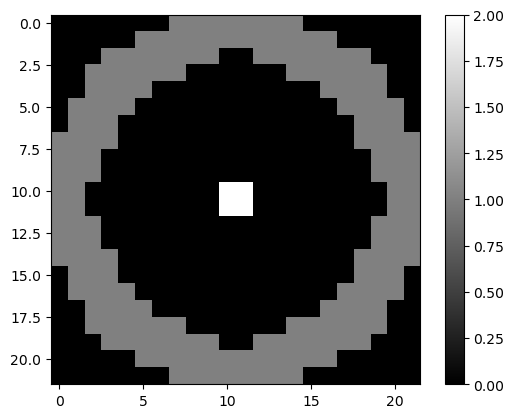

In [51]:
np_frame = np.array(im_frame)
annulus_size = len(np_frame)

## fix up imported annulus
annulus = np.zeros((annulus_size, annulus_size))
for i in range(annulus_size):
    for j in range(annulus_size):
        if (np_frame[i, j, 0] == 0 and np_frame[i, j, 3] == 255):
            annulus[i, j] = 1 ## background
        elif (np_frame[i, j, 0] == 112):
            annulus[i, j] = 2 ## star (circle aperture)
            
plt.imshow(annulus, cmap='gray')
plt.colorbar()

In [68]:
flatImg = histdata

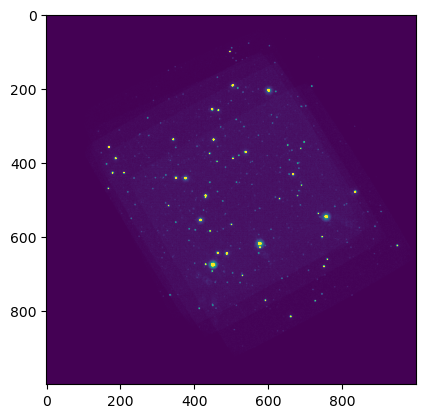

In [79]:
plt.imshow(flatImg, vmin=0, vmax=200)

In [69]:
## signal-to-noise ratio function from counting_stars_v5

def calculate_ratio (testImg, x, y):
    ## Summing counts

    circle_counts = 0
    annulus_counts = 0
    
    circle_pixels = 0
    annulus_pixels = 0

    for i in range(annulus_size):
        for j in range(annulus_size):
            try:
                if (annulus[i, j] == 2):
                    circle_counts += testImg[i + x, j + y]
                    circle_pixels += 1
                elif (annulus[i, j] == 1):
                    annulus_counts += testImg[i + x, j + y]
                    annulus_pixels += 1
            except:
                pass
                
    # Sky background per Pixel (N_s)
    sky_bg_pixel = annulus_counts / annulus_pixels

    # Signal in Aperture (N_T)
    signal = (circle_counts - (circle_pixels * annulus_counts / annulus_pixels))
    
    # Total noise = sqrt(N_T + N_s * npix + other stuff (dark current, readout))
    total_noise = np.sqrt(signal + (circle_pixels * annulus_counts / annulus_pixels))
    
    if (total_noise == 0):
        total_noise = 0.01
    
    return signal/total_noise

(200, 200)

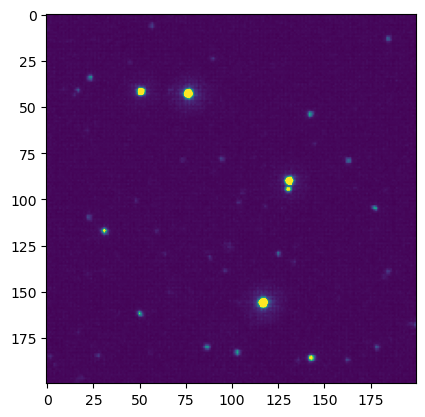

In [80]:
testImg = flatImg[400:600, 300:500]
plt.imshow(testImg, vmin=0, vmax=500)
testImg.shape

In [81]:
snrImg = np.zeros(testImg.shape)
offset = int((annulus_size + 1)/2)
for i in range(-offset, len(testImg) - offset):
    for j in range(-offset, len(testImg[0]) - offset):
        snrImg[i + offset, j + offset] = calculate_ratio(testImg, i, j)

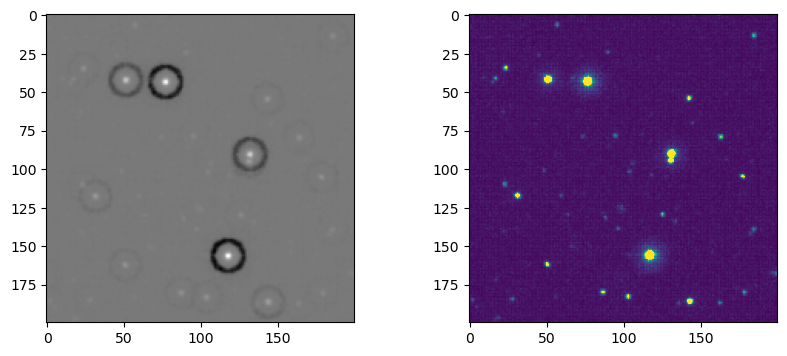

In [82]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
axes[0].imshow(snrImg, cmap='gray')
axes[1].imshow(testImg, vmin=0, vmax=200)

In [83]:
snrData = snrImg.flatten()

amp 8468.95874647032 
mean -0.3443871023065601 
sigma 1.392675659998213


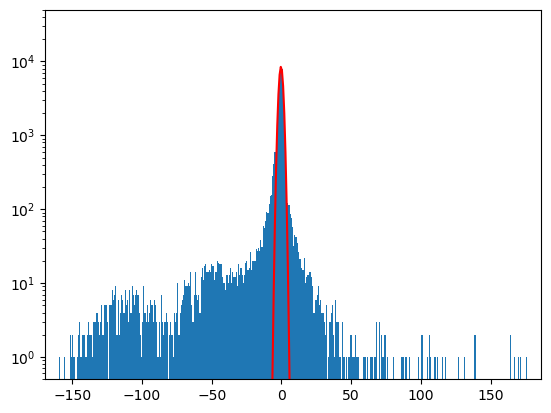

In [86]:
## histogram

n, bins, _ = plt.hist(snrData, bins=400, log=True)

## fitting gaussian curve
def gaussian (x, a, mean, sigma):
    return a * np.exp(-((x-mean)**2)/(2*sigma**2))

x = np.linspace(min(snrData), max(snrData), 400)
y = n

popt, pcov = curve_fit(gaussian, x, y)
plt.plot(x, gaussian(x, *popt), c='r')

plt.axis([min(snrData) - 10, max(snrData) + 10, 0.5, 50000])

## fit parameters
print('amp', popt[0], '\nmean', popt[1], '\nsigma', popt[2])
amp, mean, stdev = popt

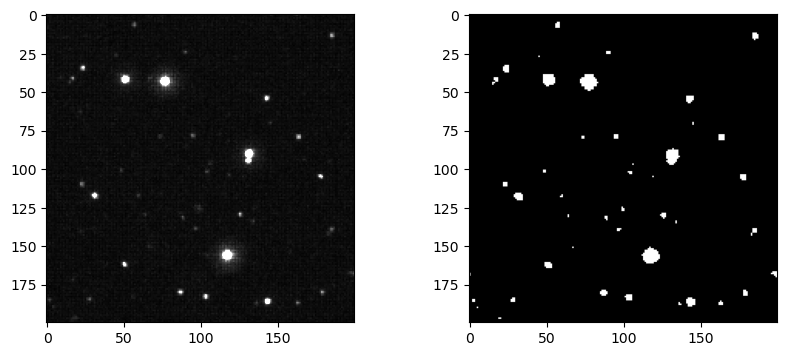

In [96]:
threshold = mean + 5 * stdev

## apply threshold on testImg
imgCut = np.zeros(snrImg.shape)

for i in range(len(snrImg)):
    for j in range(len(snrImg[0])):
        if (snrImg[i, j] >= threshold):
            imgCut[i, j] = 100
        else:
            imgCut[i, j] = 0

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
axes[0].imshow(testImg, cmap='gray', vmin=0, vmax=200)
axes[1].imshow(imgCut, cmap='gray')

In [90]:
## counting the stars

def neighbor (matrix, i, j):
    try:
        if (matrix[i - 1][j - 2] or
            matrix[i - 1][j - 1] or
            matrix[i - 1][j] or
            matrix[i - 1][j + 1] or
            matrix[i - 1][j + 2] or
            matrix[i][j - 1]):
            return 0
        else:
            return 1
    except:
        return -1

In [92]:
matrix = [[False for i in range(len(testImg[0]))] for j in range(len(testImg))]

count = 0

for i in range(len(imgCut)):
    for j in range(len(imgCut[0])):
        if (imgCut[i, j] == 100):
            matrix[i][j] = True
            if (neighbor(matrix, i, j) == 1):
                count += 1
        else:
            matrix[i][j] = False

In [94]:
count

52

In [97]:
matrix

[[False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
 

### Using DAOFinder

In [132]:
mean_bg, median_bg, bg_sd = sigma_clipped_stats(testImg, sigma=3.0)

daofind = DAOStarFinder(fwhm=8.0, threshold=2.75*bg_sd)

srcs = daofind(testImg - median_bg)

srcs

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
1,0.6057514373187385,9.141246037284455,0.7242974005757687,0.24484720117013506,0.8676259275060358,121,0.0,7.0,1.3939743860775038,-0.36063698446344217
2,184.60452060837832,13.362836491666018,0.9581167978974214,-0.06403425073922575,0.0390134584422922,121,0.0,102.0,15.925831597335703,-3.0052552977625235
3,11.593412896159446,14.408025186807304,0.680933249840736,-0.15301018817923295,-0.9692205445409678,121,0.0,6.0,1.2665768577425225,-0.25657887138177116
4,16.429124891172115,41.50842041871377,0.2355431717505497,0.12286159579991963,0.10261697909621376,121,0.0,22.0,9.4091403250584,-2.43387486379166
5,184.92093456995298,46.481172126148,0.7531309075190761,-0.16310996368452024,0.5122379123081107,121,0.0,5.0,1.1616752570284778,-0.16271184812294037
6,21.595177714200503,62.97665052059432,0.27356955148260803,0.09576241261433728,0.1837583714506139,121,0.0,5.0,2.06889117822986,-0.7893441194420124
...,...,...,...,...,...,...,...,...,...,...
23,67.07513618554059,150.29465708975954,0.41858593645663283,0.16702403472206054,-0.03372226917394776,121,0.0,10.0,2.897436937079427,-1.155034980720693
24,157.38905076896688,153.21387758915787,0.5962255224671577,0.5410639979705858,0.6876876093308226,121,0.0,5.0,1.3978425282391727,-0.3636456235013155


In [130]:
x_coords = np.array(srcs['xcentroid'])
y_coords = np.array(srcs['ycentroid'])

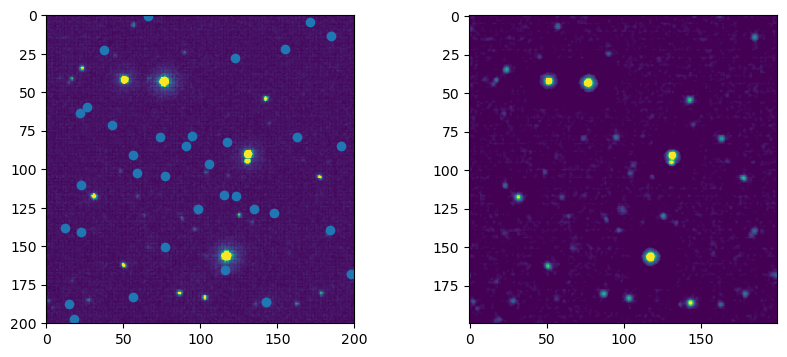

In [135]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4))

axes[0].imshow(testImg, vmin=0, vmax=200)
axes[0].scatter(x_coords, y_coords)
axes[0].set_xlim(0, 200)
axes[0].set_ylim(200, 0)

axes[1].imshow(snrImg, vmin=0, vmax=40)

## missed some of the larger stars + fainter stars
## need to actually calculate FWHM as 8 is arbitrary

## Finding the Changing Event

In [134]:
for i in range(len(matrix)):
    for j in range(len(matrix[0])):
        pass
    ## to do: filter matrix for stars, create timeseries star by star
    ## to look for changes